<a href="https://www.kaggle.com/code/yacharki/binary-classification-yelp-reviews-90-lstm?scriptVersionId=201348970" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

 # Text classification with an RNN [LSTM]

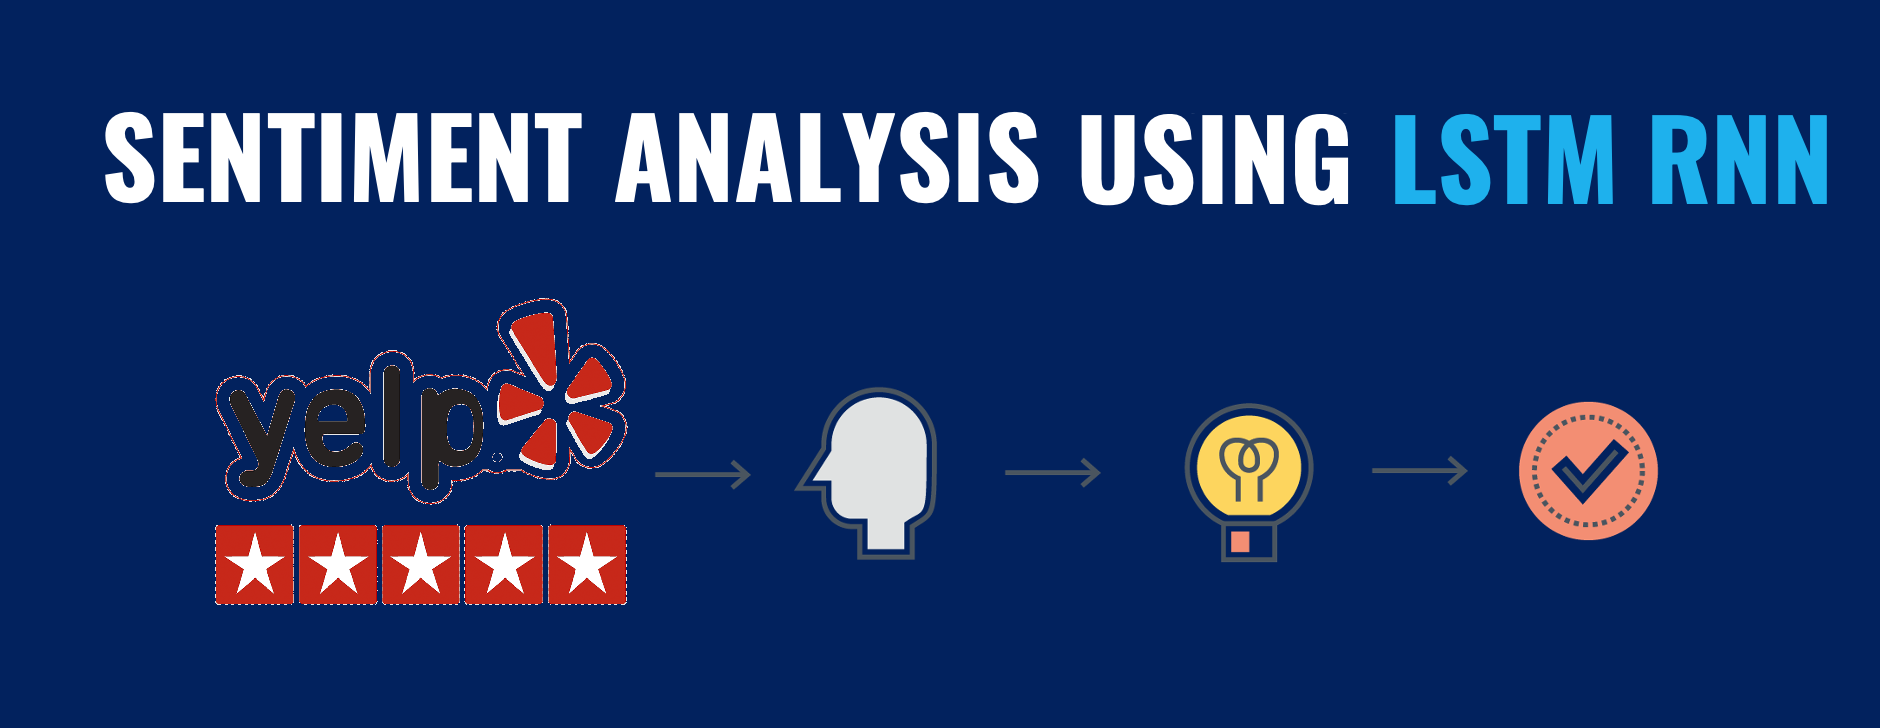

1. Download and Imports
2. Functions
3. Loading Dataset (Yelp Reviews)
4. Shuffeling and splitting the Data
5. Preprocessing and Tokenization
6. Dataset Visualization
7. Sequence Normalization and Encoding Labels
8. Model Preparation and Training
19. Visualizing and Evaluating the Results
10. Saving the model

on Github :  https://github.com/yassiracharki/DeepLearningProjrects/blob/main/binary_text_classification_yelp_reviews_90_lstm.ipynb

on Google Colab : https://colab.research.google.com/drive/1eLAQl6rFgtZUUzsdAo633Sj-AgwDXCz_?usp=sharing

# 1. Download and Imports

In [1]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 KB 13.2 MB/s eta 0:00:00
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
#Tensorflow and Keras and sklearn
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

#Charts
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Time
import time
import datetime

#Performance Plot
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata

%matplotlib inline

# fix random seed for reproducibility
seed = 3541
np.random.seed(seed)

# 2. Functions

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [4]:
# date_time function

def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

In [5]:
# Performance Plot

def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

In [6]:
# Pre-Processing Function

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = strip_html_tags(doc)
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()  
        norm_docs.append(doc)
  
    return norm_docs

# 3. Loading Dataset (Yelp Reviews)

In [7]:
dataset_train = pd.read_csv('../input/yelp-reviews-for-sentianalysis-binary-np-csv/yelp_review_sa_binary_csv/train.csv')
dataset_test = pd.read_csv('../input/yelp-reviews-for-sentianalysis-binary-np-csv/yelp_review_sa_binary_csv/test.csv')

# 4. Shuffeling and splitting the Data

In [8]:
# Shuffling Data

train = dataset_train.sample(frac=1)
test = dataset_test.sample(frac=1)

# Taking only a small peice of the dataset to avoid long training time

test = dataset_test.iloc[:38000,:]
val = dataset_train.iloc[:50000,:]
train = dataset_train.iloc[50000:,:]
train = dataset_train.iloc[:50000,:]

# Splitting data to train and validation sets manually, only including neccessary columns

X_train = train['review_text'].values
y_train = train['class_index'].values

X_val = val['review_text'].values
y_val = val['class_index'].values

X_test = test['review_text'].values
y_test = test['class_index'].values

# 5. reprocessing and Tokenization

In [9]:
%%time
#Pre-processing the Data (the Reviews)

X_train = pre_process_corpus(X_train)
X_val = pre_process_corpus(X_val)
X_test = pre_process_corpus(X_test)

  7%|▋         | 3428/50000 [00:01<00:13, 3369.78it/s]/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:343: MarkupResemblesLocatorWarning: "." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
100%|██████████| 38000/38000 [00:11<00:00, 3414.86it/s]

CPU times: user 39.4 s, sys: 583 ms, total: 40 s
Wall time: 39.7 s


In [10]:
# Tokenazing the Data (the Reviews)

t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on train documents
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0

In [11]:
# Transforming Reviews to Sequences

X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
X_val = t.texts_to_sequences(X_val)

# 6. Dataset Visualization

In [12]:
# Calculating the Vocabulary Size and the number of Reviews

print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Reviews={}".format(t.document_count))

Vocabulary size=120075
Number of Reviews=50000


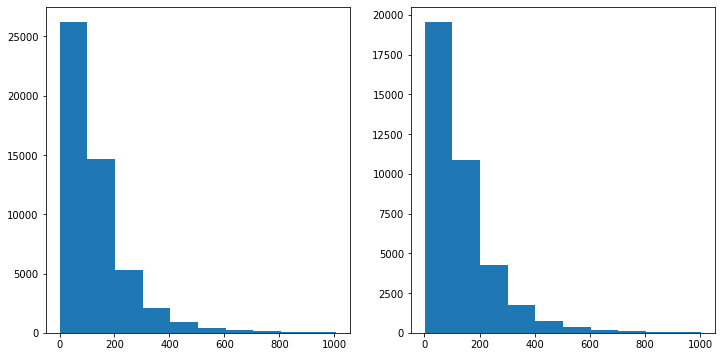

In [13]:
# Plotting the size of the sequences

import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

# 7. Sequence Normalization and Encoding Labels

In [14]:
# Padding the dataset to a maximum review length in words

X_train = sequence.pad_sequences(X_train, maxlen=800)
X_test = sequence.pad_sequences(X_test, maxlen=800)
X_val = sequence.pad_sequences(X_val, maxlen=800)

In [15]:
# Encoding Labels

le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

# 8. Model Preparation and Training

In [16]:
# Hyperparameters of the model

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 800
VOCAB_SIZE = len(t.word_index)

In [17]:
# model initialization
model = Sequential()

# The Embedding Layer
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))

# The LSTM layer (64)
model.add(LSTM(64))

# The first DEnse layer (24,relu)
model.add(Dense(24, activation='relu'))

# The first DEnse layer (24,relu)
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(loss='BinaryCrossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), 
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 800, 300)          36022500  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 36,117,525
Trainable params: 36,117,525
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Training the Model with GPU
with tf.device('/GPU:0'):
    history1 = model.fit(X_train, y_train,validation_data=(X_val,y_val), epochs=10, validation_steps=30, verbose=1)

Epoch 1/10
1563/1563 [==============================] - 69s 42ms/step - loss: 0.3543 - accuracy: 0.8397 - val_loss: 0.1725 - val_accuracy: 0.9393
Epoch 2/10
1563/1563 [==============================] - 65s 42ms/step - loss: 0.1626 - accuracy: 0.9411 - val_loss: 0.1302 - val_accuracy: 0.9522
Epoch 3/10
1563/1563 [==============================] - 65s 42ms/step - loss: 0.1139 - accuracy: 0.9606 - val_loss: 0.0747 - val_accuracy: 0.9766
Epoch 4/10
1563/1563 [==============================] - 65s 42ms/step - loss: 0.0817 - accuracy: 0.9727 - val_loss: 0.0650 - val_accuracy: 0.9773
Epoch 5/10
1563/1563 [==============================] - 65s 42ms/step - loss: 0.0601 - accuracy: 0.9803 - val_loss: 0.0422 - val_accuracy: 0.9884
Epoch 6/10
1563/1563 [==============================] - 65s 42ms/step - loss: 0.0465 - accuracy: 0.9849 - val_loss: 0.0318 - val_accuracy: 0.9910
Epoch 7/10
1563/1563 [==============================] - 65s 42ms/step - loss: 0.0332 - accuracy: 0.9897 - val_loss: 0.0211 -

# 9. Visualizing and Evaluating the Results

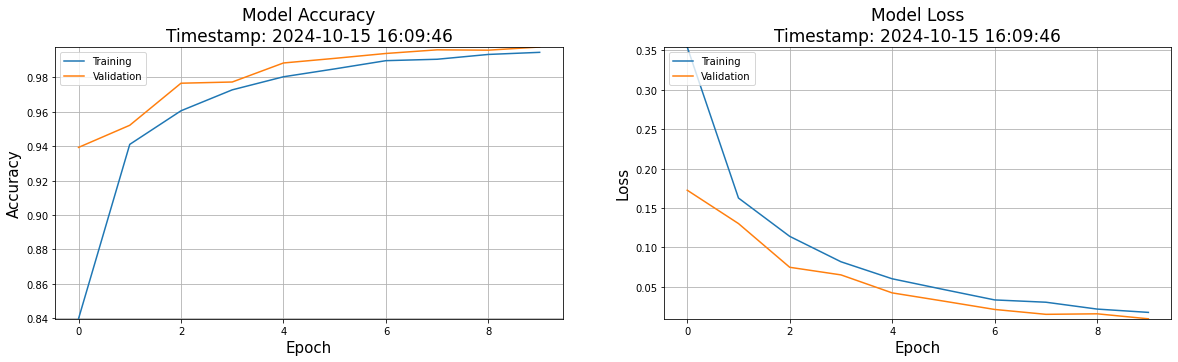

In [19]:
#Accuracy / Validation_Accuracy  and Loss / Validation_Loss Plot

plot_performance(history=history1)

In [20]:
# Final evaluation of the model

scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1188/1188 [==============================] - 15s 13ms/step - loss: 0.4503 - accuracy: 0.9050
Accuracy: 90.50%


# 10. Saving the model

In [21]:
model.save('Binary_Classification_90_Yelp_Reviews_LSTM.h5')